In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

In [27]:
# Load the data
df = pd.read_csv('data_temp.csv', names=['Year', 'Degrees'], skiprows=1)

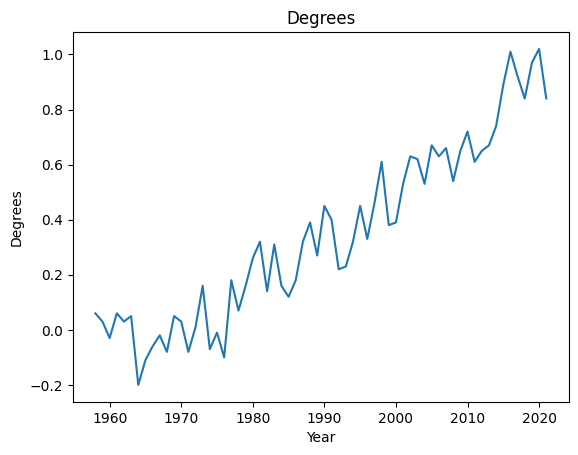

In [28]:
plt.plot(df['Year'], df['Degrees'])
plt.xlabel('Year')
plt.ylabel('Degrees')
plt.title('Degrees')
plt.show()

In [29]:
df.drop('Year', axis=1, inplace=True)
data = df.values


def normalize(data, min, max):
    data = data - min
    data = data / (max - min)
    return data


def unnormalize(data, min, max):
    data = data * (max - min)
    data = data + min
    return data


data_normed = normalize(data, data.min(axis=0), data.max(axis=0))
data_normed[:10]

array([[0.21311475],
       [0.18852459],
       [0.13934426],
       [0.21311475],
       [0.18852459],
       [0.20491803],
       [0.        ],
       [0.07377049],
       [0.1147541 ],
       [0.14754098]])

In [32]:
split = int(0.8 * len(data_normed))
train, val = data_normed[:split], data_normed[split:]


def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    '''
    :param series: an iterable
    :param batch_size: number of samples per batch
    :param n_past: number of timesteps to look back (x or input to the model)
    :param n_future: number of timesteps to predict (y or output of the model)
    :param shift: number of timesteps to shift the window by, usually 1 if we want to maximise the use of data
    :return:
    '''
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_future], w[n_future:]))  # taking the past as x, future as y, split by n_past
    ds.shuffle(8192)
    return ds.batch(batch_size).prefetch(1)


batch_size = 32  # explore how changing this affects the model (it is not as simple as larger batch size = better performance, lik ein image tasks)
n_past = 5
n_future = 5
shift = 1

train_ds = windowed_dataset(train, batch_size, n_past, n_future, shift)
valid_ds = windowed_dataset(val, batch_size, n_past, n_future, shift)

In [33]:
xIn = tf.keras.layers.Input(shape=(n_past,
                                   1))  # 20 input, where first dimension is the number of timesteps to look back, 2nd dimension is the number of features
x = tf.keras.layers.LSTM(32, return_sequences=True)(xIn)  # LSTM layer with 32 hidden units. Return
x = tf.keras.layers.LSTM(32)(x)
xOut = tf.keras.layers.Dense(n_future)(x)
model = tf.keras.Model(inputs=xIn, outputs=xOut)
model.compile(loss='mse', optimizer='adam', metrics='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 5, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 12,837
Trainable params: 12,837
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(train_ds, epochs=100, validation_data=valid_ds)

Epoch 1/100
2/2 [==============================] - 8s 3s/step - loss: 0.1695 - mse: 0.1695 - val_loss: 0.8240 - val_mse: 0.8240
Epoch 2/100
2/2 [==============================] - 0s 63ms/step - loss: 0.1605 - mse: 0.1605 - val_loss: 0.7936 - val_mse: 0.7936
Epoch 3/100
2/2 [==============================] - 0s 61ms/step - loss: 0.1519 - mse: 0.1519 - val_loss: 0.7624 - val_mse: 0.7624
Epoch 4/100
2/2 [==============================] - 0s 62ms/step - loss: 0.1431 - mse: 0.1431 - val_loss: 0.7298 - val_mse: 0.7298
Epoch 5/100
2/2 [==============================] - 0s 63ms/step - loss: 0.1340 - mse: 0.1340 - val_loss: 0.6954 - val_mse: 0.6954
Epoch 6/100
2/2 [==============================] - 0s 47ms/step - loss: 0.1245 - mse: 0.1245 - val_loss: 0.6587 - val_mse: 0.6587
Epoch 7/100
2/2 [==============================] - 0s 47ms/step - loss: 0.1146 - mse: 0.1146 - val_loss: 0.6192 - val_mse: 0.6192
Epoch 8/100
2/2 [==============================] - 0s 66ms/step - loss: 0.1042 - mse: 0.1042

1/1 [==============================] - 0s 31ms/step


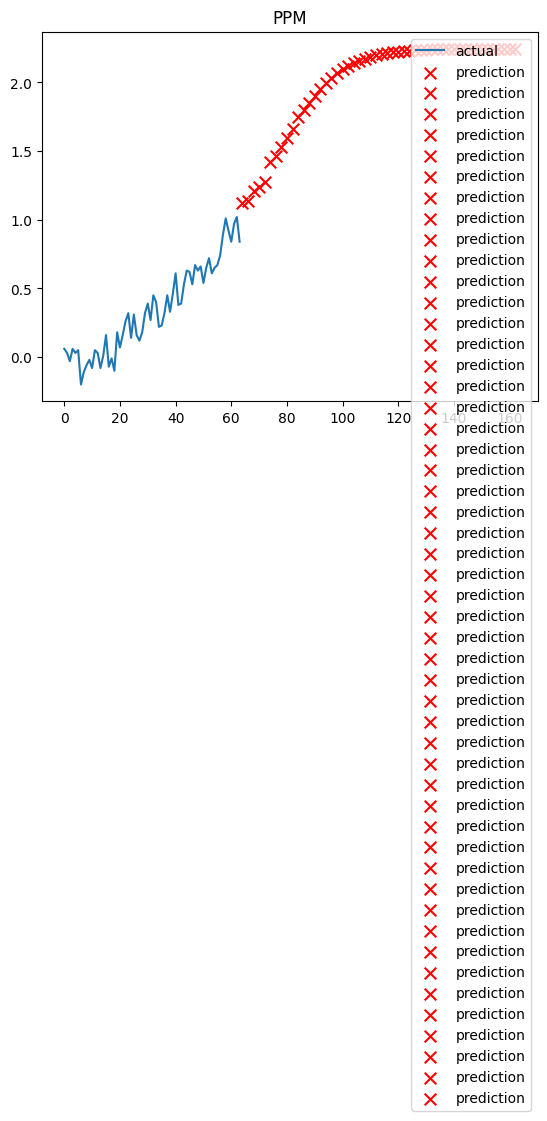

In [35]:
plt.plot(unnormalize(data_normed, data.min(axis=0), data.max(axis=0)),
         label='actual')  # our val was taken as subset of the normaized data so we need to unnormalize it here
# plt.plot(unnormalize(pred[0][0], data.min(axis=0), data.max(axis=0)), label='prediction')

for i in range(50):
    new_forecast_series = data_normed[-n_past:]
    pred = model.predict(new_forecast_series.reshape(5,1)[np.newaxis])

    plt.scatter(len(data_normed)+i, unnormalize(pred[:,0], data.min(axis=0), data.max(axis=0)), color="red", marker="x", s=70, label="prediction")

    data_normed = np.concatenate((data_normed, pred[:, 0]), axis=None)


plt.legend()
plt.title('PPM')
plt.show()